In [5]:
# 1) IMPORTS
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

In [20]:
from google.colab import files
uploaded = files.upload()


Saving mental_health_workplace_survey.csv to mental_health_workplace_survey (3).csv


In [23]:
# 2) LOAD DATA
import pandas as pd
df = pd.read_csv("mental_health_workplace_survey.csv")
print("Original data shape:", df.shape)
print(df.head())
print("Columns:", df.columns.tolist())

Original data shape: (3000, 25)
   EmployeeID  Age      Gender    Country            JobRole Department  \
0        1001   50        Male         UK    Sales Associate         HR   
1        1002   36        Male    Germany  Software Engineer         IT   
2        1003   29  Non-binary      India           IT Admin         IT   
3        1004   42        Male  Australia      HR Specialist         IT   
4        1005   40        Male     Brazil   Customer Support    Support   

   YearsAtCompany  WorkHoursPerWeek RemoteWork  BurnoutLevel  ...  \
0              14                47         No          3.37  ...   
1               1                59     Hybrid          7.39  ...   
2              13                59     Hybrid          7.10  ...   
3              15                31        Yes          4.18  ...   
4               6                34        Yes          8.28  ...   

   CommuteTime  HasMentalHealthSupport  ManagerSupportScore  HasTherapyAccess  \
0          117       

In [10]:
# 3) CHECK TARGET DISTRIBUTION
print("\nTarget distribution:\n", df['BurnoutRisk'].value_counts())

Target distribution:
 BurnoutRisk
0    3000
Name: count, dtype: int64


In [26]:
# 4) FEATURES + TARGET
X = df[["WorkHoursPerWeek", "BurnoutLevel", "WorkLifeBalanceScore", "CareerGrowthScore"]]
y = df["BurnoutRisk"]
print("\nBefore SMOTE target distribution:\n", y.value_counts())


Before SMOTE target distribution:
 BurnoutRisk
0    2020
1     980
Name: count, dtype: int64


In [27]:
# 5) BALANCE DATA WITH SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

In [28]:
# 6) TRAIN/TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

In [29]:
# 7) TRAIN LOGISTIC REGRESSION
log_reg = LogisticRegression(max_iter=2000, solver="lbfgs")
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=2000)

In [30]:
# 8) EVALUATE MODEL
y_pred = log_reg.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       604
           1       0.99      1.00      1.00       608

    accuracy                           1.00      1212
   macro avg       1.00      1.00      1.00      1212
weighted avg       1.00      1.00      1.00      1212



In [31]:
cv_scores = cross_val_score(log_reg, X_res, y_res, cv=5)
print("Cross-validation accuracy:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())

Cross-validation accuracy: [0.99752475 0.99381188 0.99752475 0.99752475 0.99381188]
Mean CV accuracy: 0.996039603960396


In [32]:
# 9) FUNCTION TO PREDICT NEW INPUTS
def predict_burnout(model, sample):
    """
    sample: dictionary with feature names as keys
    """
    sample_df = pd.DataFrame([sample])
    prob = model.predict_proba(sample_df)[0][1]  # probability of burnout
    label = "YES" if prob >= 0.5 else "NO"
    return f"Burnout Risk: {label} ({prob*100:.2f}% probability)"


In [34]:
# 10) TEST THE FUNCTION WITH NEW INPUTS
cases = [
    {"WorkHoursPerWeek": 40, "BurnoutLevel": 3, "WorkLifeBalanceScore": 8, "CareerGrowthScore": 9},  # healthy
    {"WorkHoursPerWeek": 70, "BurnoutLevel": 9, "WorkLifeBalanceScore": 2, "CareerGrowthScore": 2},  # high burnout
    {"WorkHoursPerWeek": 55, "BurnoutLevel": 7, "WorkLifeBalanceScore": 5, "CareerGrowthScore": 5},  # borderline
    {"WorkHoursPerWeek": 85, "BurnoutLevel": 10, "WorkLifeBalanceScore": 1, "CareerGrowthScore": 1}, # extreme burnout
]

for i, case in enumerate(cases, 1):
    print(f"Case {i} →", predict_burnout(log_reg, case))

Case 1 → Burnout Risk: NO (0.00% probability)
Case 2 → Burnout Risk: YES (100.00% probability)
Case 3 → Burnout Risk: YES (65.37% probability)
Case 4 → Burnout Risk: YES (100.00% probability)


In [38]:
test_cases = [
    {"WorkHoursPerWeek": 35, "BurnoutLevel": 2, "WorkLifeBalanceScore": 8, "CareerGrowthScore": 9},  # very healthy
    {"WorkHoursPerWeek": 45, "BurnoutLevel": 5, "WorkLifeBalanceScore": 7, "CareerGrowthScore": 7},  # low risk
    {"WorkHoursPerWeek": 50, "BurnoutLevel": 6, "WorkLifeBalanceScore": 5, "CareerGrowthScore": 5},  # borderline
    {"WorkHoursPerWeek": 60, "BurnoutLevel": 7, "WorkLifeBalanceScore": 4, "CareerGrowthScore": 4},  # moderate burnout
    {"WorkHoursPerWeek": 65, "BurnoutLevel": 8, "WorkLifeBalanceScore": 3, "CareerGrowthScore": 3},  # high burnout
    {"WorkHoursPerWeek": 70, "BurnoutLevel": 9, "WorkLifeBalanceScore": 2, "CareerGrowthScore": 2},  # extreme burnout
    {"WorkHoursPerWeek": 55, "BurnoutLevel": 7, "WorkLifeBalanceScore": 5, "CareerGrowthScore": 5},  # borderline
    {"WorkHoursPerWeek": 40, "BurnoutLevel": 4, "WorkLifeBalanceScore": 7, "CareerGrowthScore": 8},  # healthy
    {"WorkHoursPerWeek": 80, "BurnoutLevel": 10, "WorkLifeBalanceScore": 1, "CareerGrowthScore": 1}, # extreme burnout
    {"WorkHoursPerWeek": 50, "BurnoutLevel": 6, "WorkLifeBalanceScore": 5, "CareerGrowthScore": 4},  # moderate burnout
]

# Run predictions and store them
predictions = []
for i, case in enumerate(test_cases, 1):
    prediction_result = predict_burnout(log_reg, case)
    print(f"Case {i} →", prediction_result)
    predictions.append(prediction_result)

Case 1 → Burnout Risk: NO (0.00% probability)
Case 2 → Burnout Risk: NO (0.00% probability)
Case 3 → Burnout Risk: NO (0.04% probability)
Case 4 → Burnout Risk: YES (69.59% probability)
Case 5 → Burnout Risk: YES (99.99% probability)
Case 6 → Burnout Risk: YES (100.00% probability)
Case 7 → Burnout Risk: YES (65.37% probability)
Case 8 → Burnout Risk: NO (0.00% probability)
Case 9 → Burnout Risk: YES (100.00% probability)
Case 10 → Burnout Risk: NO (0.04% probability)


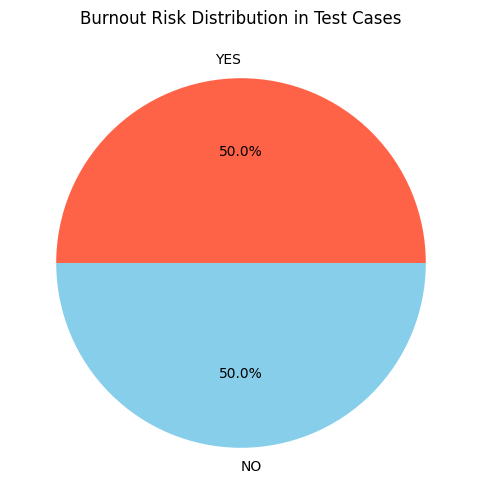

In [39]:
import matplotlib.pyplot as plt

# Count YES/NO
yes_count = sum(1 for p in predictions if "YES" in p)
no_count  = sum(1 for p in predictions if "NO" in p)

plt.figure(figsize=(6,6))
plt.pie([yes_count, no_count], labels=["YES", "NO"], autopct='%1.1f%%', colors=["tomato","skyblue"])
plt.title("Burnout Risk Distribution in Test Cases")
plt.show()

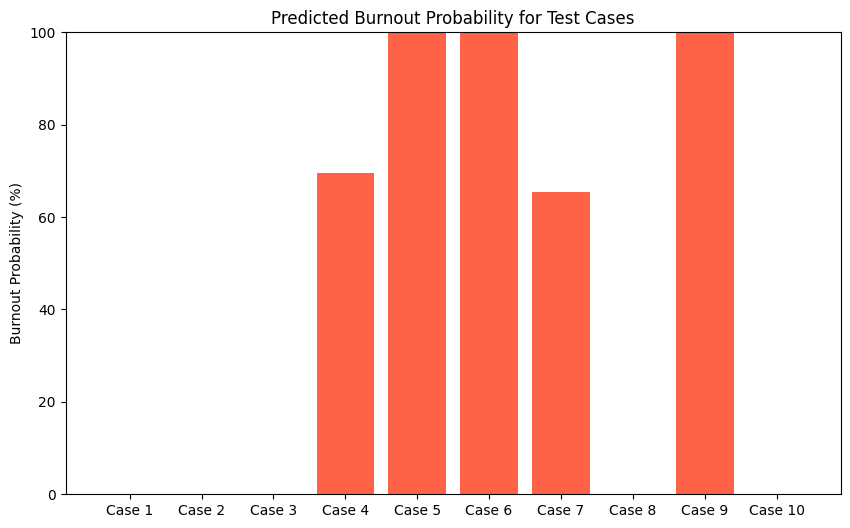

In [40]:
import matplotlib.pyplot as plt

# Prepare data
predictions = [predict_burnout(log_reg, case) for case in test_cases]
probabilities = [float(p.split('(')[1].replace('% probability)','')) for p in predictions]
case_labels = [f"Case {i+1}" for i in range(len(test_cases))]

# Plot
plt.figure(figsize=(10,6))
plt.bar(case_labels, probabilities, color='tomato')
plt.ylim(0, 100)
plt.ylabel("Burnout Probability (%)")
plt.title("Predicted Burnout Probability for Test Cases")
plt.show()


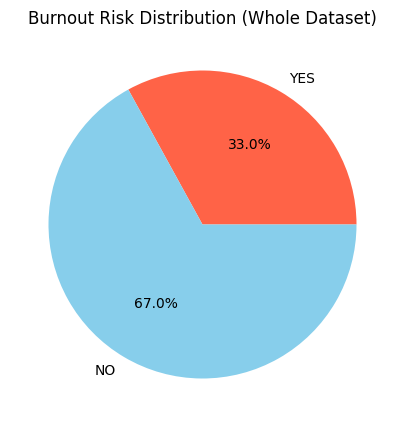

In [48]:
# Predict burnout for the whole dataset
all_predictions = [predict_burnout(log_reg, row) for idx, row in df[feature_cols].iterrows()]

yes_count = sum(1 for p in all_predictions if "YES" in p)
no_count  = sum(1 for p in all_predictions if "NO" in p)

plt.figure(figsize=(5,5))
plt.pie([yes_count, no_count], labels=["YES", "NO"], autopct='%1.1f%%', colors=["tomato","skyblue"])
plt.title("Burnout Risk Distribution (Whole Dataset)")
plt.show()

